# Week Eleven: NLI with Attention

In this assignment we train an attention-based model for NLI based on [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) base (non word-by-word) model.

## Setup

You'll need to download and unzip SNLI, which you can find [here](http://nlp.stanford.edu/projects/snli/). Set `snli_home` below to point to it. The following block of code loads it.

This will take a couple of minutes to run, so you may want to start editing the code below at the same time.

In [156]:
snli_home = '../snli_1.0'

import re
import random
import json

LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2
}

def load_snli_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f):
            if i >= 1000000:  # Edit to use less data.
                break
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
        random.seed(1)
        random.shuffle(data)
    return data
     
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl')

# Note: Unlike with k-nearest neighbors, evaluation here should be fast, and we don't need to
# trim down the dev and test sets. 

Next, we'll convert the data to index vectors in the same way that we've done for in-class exercises with RNN-based sentiment models. A few notes:

- We use a sequence length of only 10, which is short enough that we're truncating a large fraction of sentences.
- Tokenization is easy here because we're relying on the output of a parser (which does tokenization as part of parsing), just as with the SST corpus that we've been using until now. Note that we use the 'sentence1_binary_parse' field of each example rather than the human-readable 'sentence1'.
- We're using a moderately large vocabulary (for a class exercise) of about 12k words.

In [157]:
SEQ_LEN = 10

import collections
import numpy as np

def sentences_to_padded_index_sequences(datasets):
    '''Annotates datasets with feature vectors.'''
    
    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    
    # Extract vocabulary
    def tokenize(string):
        string = re.sub(r'\(|\)', '', string)
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['sentence1_binary_parse']))
        word_counter.update(tokenize(example['sentence2_binary_parse']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            for sentence in ['sentence1_binary_parse', 'sentence2_binary_parse']:
                example[sentence + '_index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

                token_sequence = tokenize(example[sentence])
                padding = SEQ_LEN - len(token_sequence)

                for i in range(SEQ_LEN):
                    if i >= padding:
                        if token_sequence[i - padding] in word_indices:
                            index = word_indices[token_sequence[i - padding]]
                        else:
                            index = word_indices[UNKNOWN]
                    else:
                        index = word_indices[PADDING]
                    example[sentence + '_index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentences_to_padded_index_sequences([training_set, dev_set, test_set])

In [158]:
print training_set[6]
print len(word_indices)

{u'annotator_labels': [u'contradiction'], u'sentence2_parse': u'(ROOT (NP (NP (NNS People)) (PP (IN on) (NP (DT a) (NN bike))) (PP (IN on) (NP (DT a) (NN beach))) (. .)))', u'sentence1_binary_parse': u'( ( Five men ) ( ( are ( ( ( playing ( musical instruments ) ) together ) ( on ( a stage ) ) ) ) . ) )', u'captionID': u'2430018178.jpg#1', 'sentence1_binary_parse_index_sequence': array([ 4427, 35502, 23868,  2606,  7654, 11706, 16853, 30670, 11078,   378], dtype=int32), 'label': 2, u'sentence2_binary_parse': u'( ( ( People ( on ( a bike ) ) ) ( on ( a beach ) ) ) . )', u'pairID': u'2430018178.jpg#1r1c', u'sentence2': u'People on a bike on a beach.', u'sentence1_parse': u'(ROOT (S (NP (CD Five) (NNS men)) (VP (VBP are) (VP (VBG playing) (NP (JJ musical) (NNS instruments)) (ADVP (RB together)) (PP (IN on) (NP (DT a) (NN stage))))) (. .)))', 'sentence2_binary_parse_index_sequence': array([    0,     0,  9336, 16853, 30670, 20331, 16853, 30670, 20428,   378], dtype=int32), u'gold_label': u

Now we load GloVe. You'll need the same file that you used for the in-class exercise on word embeddings.

In [159]:
glove_home = '../'
words_to_load = 25000

with open(glove_home + 'glove.6B.50d.txt') as f:
    loaded_embeddings = np.zeros((len(word_indices), 50), dtype='float32')
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        
        s = line.split()
        if s[0] in word_indices:
            loaded_embeddings[word_indices[s[0]], :] = np.asarray(s[1:])

Now we set up an evaluation function as before.

In [160]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## The Model

Run the first block of code right away to make sure you have the proper dependencies. You may need to install [matplotlib](http://matplotlib.org/users/installing.html), which should be fairly straightforward.

Fill in the missing componant below to complete Rocktäschel-style attention.

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt

In [162]:
import tensorflow as tf

In [163]:
class RNNEntailmentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.training_epochs = 5  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to print out cost statistics (in epochs)
        self.display_step_freq = 250  # How often to test (in steps)
        self.dim = 24  # The dimension of the hidden state of the RNN
        self.embedding_dim = 50  # The dimension of the learned word embeddings
        self.batch_size = 64  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        
        # Define the parameters
        self.E = tf.Variable(loaded_embeddings, trainable=False)
        
        self.W_rnn = {}
        self.W_r = {}
        self.W_z = {}
        self.b_rnn = {}
        self.b_r = {}
        self.b_z = {}
        
        for name in ['p', 'h']:
            in_dim = self.embedding_dim
            
            self.W_rnn[name] = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_rnn[name] = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

            self.W_r[name] = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_r[name] = tf.Variable(tf.random_normal([self.dim], stddev=0.1))

            self.W_z[name] = tf.Variable(tf.random_normal([in_dim + self.dim, self.dim], stddev=0.1))
            self.b_z[name] = tf.Variable(tf.random_normal([self.dim], stddev=0.1))         

        # TODO: You'll need to use these three parameters.
        self.W_h_attn = tf.Variable(tf.random_normal([self.dim, self.dim], stddev=0.1))
        self.W_y_attn = tf.Variable(tf.random_normal([self.dim, self.dim], stddev=0.1))
        self.w_attn = tf.Variable(tf.random_normal([self.dim, 1], stddev=0.1))

        self.W_combination = tf.Variable(tf.random_normal([2 * self.dim, self.dim], stddev=0.1))
        self.b_combination = tf.Variable(tf.random_normal([self.dim], stddev=0.1))
        
        self.W_cl = tf.Variable(tf.random_normal([self.dim, 3], stddev=0.1))
        self.b_cl = tf.Variable(tf.random_normal([3], stddev=0.1))
        
        # Define the placeholders
        self.premise_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.hypothesis_x = tf.placeholder(tf.int32, [None, self.sequence_length])
        self.y = tf.placeholder(tf.int32, [None])
        
        # Define the GRU function
        def gru(emb, h_prev, name):
            emb_h_prev = tf.concat(1, [emb, h_prev], name=name + '_emb_h_prev')
            z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z[name])  + self.b_z[name], name=name + '_z')
            r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r[name])  + self.b_r[name], name=name + '_r')
            emb_r_h_prev = tf.concat(1, [emb, r * h_prev], name=name + '_emb_r_h_prev')
            h_tilde = tf.nn.tanh(tf.matmul(emb_r_h_prev, self.W_rnn[name])  + self.b_rnn[name], name=name + '_h_tilde')
            h = (1. - z) * h_prev + z * h_tilde
            return h
        
        # Define one step of the premise encoder RNN
        def premise_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru(emb, h_prev, 'p')
        
        # Define one step of the hypothesis encoder RNN
        def hypothesis_step(x, h_prev):
            emb = tf.nn.embedding_lookup(self.E, x)
            return gru(emb, h_prev, 'h')

        # Split up the inputs into individual tensors
        self.x_premise_slices = tf.split(1, self.sequence_length, self.premise_x)
        self.x_hypothesis_slices = tf.split(1, self.sequence_length, self.hypothesis_x)
        
        self.h_zero = tf.zeros(tf.pack([tf.shape(self.premise_x)[0], self.dim]))
        
        # Unroll the first RNN
        premise_h_prev = self.h_zero
        premise_steps_list = []

        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_premise_slices[t], [-1])
            premise_h_prev = premise_step(x_t, premise_h_prev)
            premise_steps_list.append(premise_h_prev)
            
        premise_steps = tf.pack(premise_steps_list, axis=1, name='premise_steps')
 
        # Unroll the second RNN
        h_prev_hypothesis = premise_h_prev  # Continue running the same RNN
        
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_hypothesis_slices[t], [-1])
            h_prev_hypothesis = hypothesis_step(x_t, h_prev_hypothesis)
        
        # Do attention
        wm_list = []
        
        # TODO: Fill wm_list with one scalar (a.k.a., vector with one scalar for each batch entry)
        # for each word in the premise.
        # This'll likely be easiest if you use a loop to iterate over timesteps.
        # You should use the three `attn` parameters defined above, as well as `premise_steps_list`.
        
        wm = tf.pack(wm_list, axis=1)        
        self.attn_weights = tf.nn.softmax(wm, dim=1)
        attn_result = tf.reduce_sum(tf.mul(self.attn_weights, premise_steps, name='attn_result_unsummed'),
                                    1, name='attn_result')
        
        # Combine the results of attention with the final GRU state
        concat_features = tf.concat(1, [attn_result, h_prev_hypothesis], name=name + '_emb_h_prev')
        pair_features = tf.nn.tanh(tf.matmul(concat_features, self.W_combination) + self.b_combination)
        
        # Compute the logits
        self.logits = tf.matmul(pair_features, self.W_cl) + self.b_cl
        
        # Define the cost function (here, the softmax exp and sum are built in)
        self.total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits, self.y))
        
        # This  performs the main SGD update equation with gradient clipping
        optimizer_obj = tf.train.AdamOptimizer()
        gvs = optimizer_obj.compute_gradients(self.total_cost)
        capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
        self.optimizer = optimizer_obj.apply_gradients(capped_gvs)
        
        # Create an operation to fill zero values in for W and b
        self.init = tf.initialize_all_variables()

        # Create a placeholder for the session that will be shared between training and evaluation
        self.sess = tf.Session()
        
        # Initialize variables
        self.sess.run(self.init)
        self.step = 1
        self.epoch = 1
        
    def train(self, training_data, dev_data):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            premise_vectors = np.vstack([dataset[i]['sentence1_binary_parse_index_sequence'] for i in indices])
            hypothesis_vectors = np.vstack([dataset[i]['sentence2_binary_parse_index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return premise_vectors, hypothesis_vectors, labels

        print 'Training.'

        # Training cycle
        for _ in range(self.training_epochs):
            random.shuffle(training_data)
            avg_cost = 0.
            total_batch = int(len(training_data) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_premise_vectors, minibatch_hypothesis_vectors, minibatch_labels = get_minibatch(
                    training_data, self.batch_size * i, self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                _, c = self.sess.run(
                     [self.optimizer, self.total_cost], 
                     feed_dict={self.premise_x: minibatch_premise_vectors,
                                self.hypothesis_x: minibatch_hypothesis_vectors,
                                self.y: minibatch_labels})

                if self.step % self.display_step_freq == 0:
                    print "Step:", self.step, "Dev acc:", evaluate_classifier(self.classify, dev_data[0:1000]), \
                        "Train acc:", evaluate_classifier(self.classify, training_data[0:1000]) 
                                  
                self.step += 1
                avg_cost += c / (total_batch * self.batch_size)
                                
            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if self.epoch % self.display_epoch_freq == 0:
                print "Epoch:", self.epoch, "Cost:", avg_cost 
            self.epoch += 1
    
    def classify(self, examples):
        # This classifies a list of examples
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        logits = self.sess.run(self.logits,
                               feed_dict={self.premise_x: premise_vectors,
                                          self.hypothesis_x: hypothesis_vectors})

        return np.argmax(logits, axis=1)

    def get_attn(self, examples):
        premise_vectors = np.vstack([example['sentence1_binary_parse_index_sequence'] for example in examples])
        hypothesis_vectors = np.vstack([example['sentence2_binary_parse_index_sequence'] for example in examples])
        attn_weights = self.sess.run(self.attn_weights, 
                                     feed_dict={self.premise_x: premise_vectors,
                                                self.hypothesis_x: hypothesis_vectors})
        return np.reshape(attn_weights, [len(examples), 10, 1])
        
    def plot_attn(self, examples):
        attn_weights = self.get_attn(examples)

        for i in range(len(examples)):    
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.matshow(np.transpose(attn_weights[i,:,:]), vmin=0., vmax=1., cmap=plt.cm.inferno)
            premise_tokens = [indices_to_words[index] for index in examples[i]['sentence1_binary_parse_index_sequence']]
            hypothesis_tokens = [indices_to_words[index] for index in examples[i]['sentence2_binary_parse_index_sequence']]
            plt.text(0, 1, 'H: ' + ' '.join(hypothesis_tokens))
            ax.set_xticklabels(premise_tokens, rotation=45)
            plt.xticks(np.arange(0, 10, 1.0))

Next, create an instance of the model. Unlike in previous exercises, initialization happens here, rather than at the start of training. You can now initialize a model once and start and stop training as needed.

In [164]:
classifier = RNNEntailmentClassifier(len(word_indices), SEQ_LEN)

In implementing attention, it's easy to accidentally mix information between different examples in a batch. This assertion will fail if you've done so. Run it whenever you edit core model code.

In [165]:
assert (classifier.get_attn(training_set[0:2])[0, :, :] == \
        classifier.get_attn(training_set[0:3])[0, :, :]).all(), \
       'Warning: There is cross-example information flow.'

Run the model below until you get to around 62% dev accuracy. This should take around five or ten minutes. This isn't great performance, but it's good enough that we should start to see attention play a role. If you have extra time, run longer.

In [166]:
classifier.train(training_set, dev_set)

Training.
Step: 250 Dev acc: 0.518 Train acc: 0.517
Step: 500 Dev acc: 0.541 Train acc: 0.561
Step: 750 Dev acc: 0.541 Train acc: 0.556
Step: 1000 Dev acc: 0.572 Train acc: 0.57
Step: 1250 Dev acc: 0.57 Train acc: 0.574
Step: 1500 Dev acc: 0.588 Train acc: 0.558
Step: 1750 Dev acc: 0.583 Train acc: 0.589
Step: 2000 Dev acc: 0.595 Train acc: 0.592
Step: 2250 Dev acc: 0.617 Train acc: 0.583
Step: 2500 Dev acc: 0.599 Train acc: 0.589
Step: 2750 Dev acc: 0.592 Train acc: 0.606
Step: 3000 Dev acc: 0.604 Train acc: 0.599
Step: 3250 Dev acc: 0.606 Train acc: 0.603
Step: 3500 Dev acc: 0.601 Train acc: 0.602
Step: 3750 Dev acc: 0.62 Train acc: 0.604
Step: 4000 Dev acc: 0.618 Train acc: 0.595
Step: 4250 Dev acc: 0.619 Train acc: 0.605
Step: 4500 Dev acc: 0.612 Train acc: 0.6
Step: 4750 Dev acc: 0.613 Train acc: 0.601
Step: 5000 Dev acc: 0.595 Train acc: 0.599
Step: 5250 Dev acc: 0.614 Train acc: 0.621
Step: 5500 Dev acc: 0.619 Train acc: 0.598
Step: 5750 Dev acc: 0.62 Train acc: 0.613
Step: 6000

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

In [168]:
## Visualization

This will print some (NYU-colored) visualizations for the first ten dev examples. Explore these examples and more, and see if you can identify any patterns in what the model has learned.

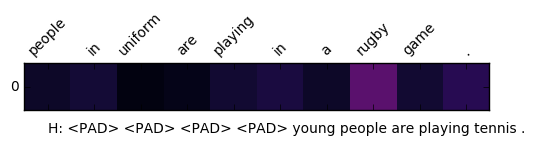

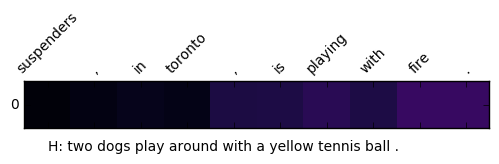

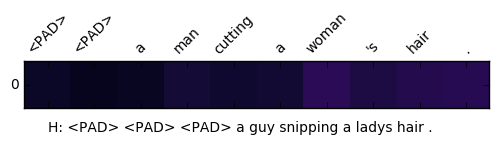

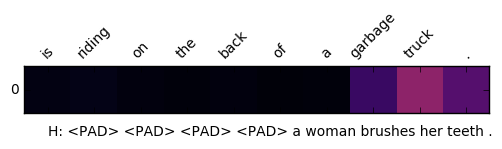

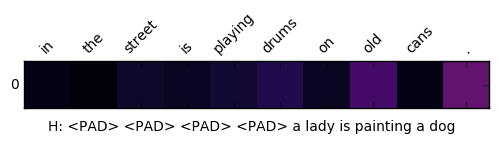

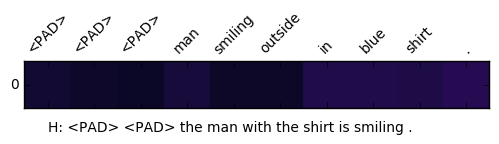

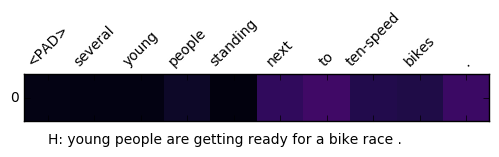

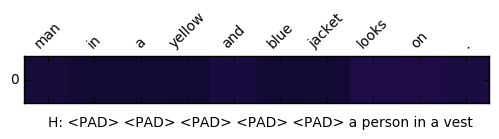

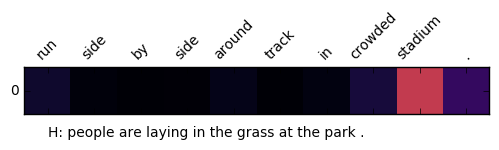

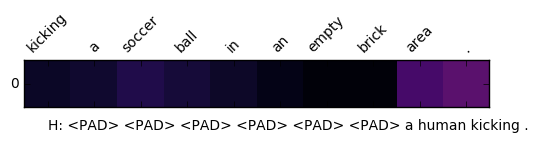

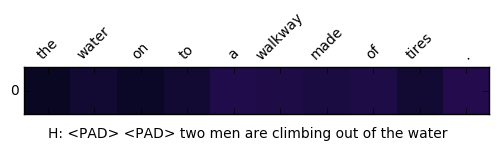

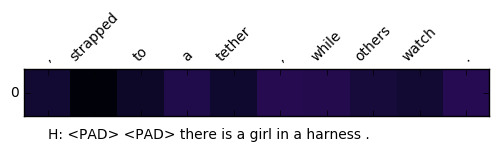

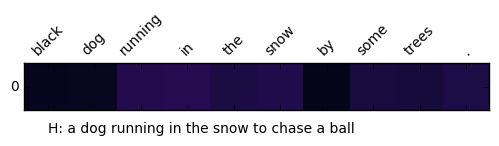

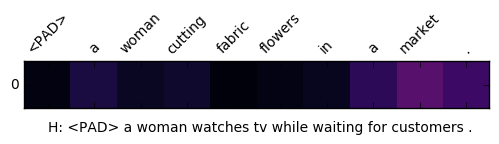

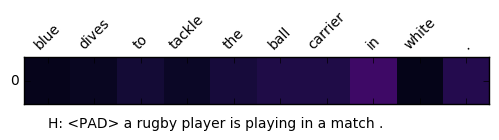

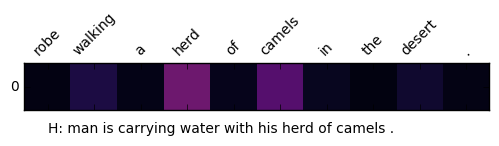

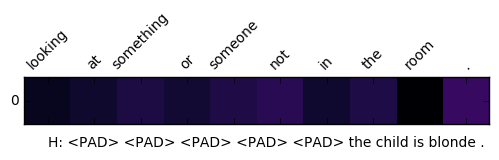

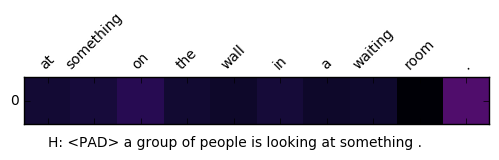

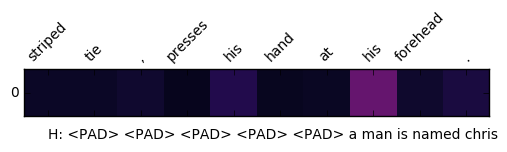

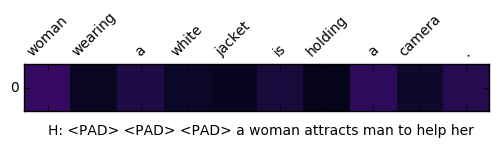

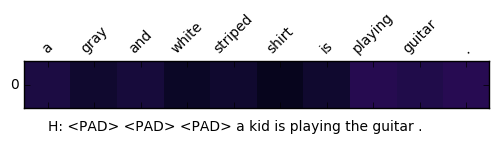

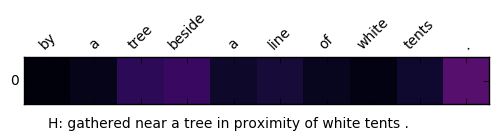

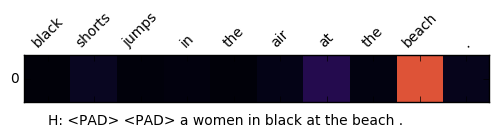

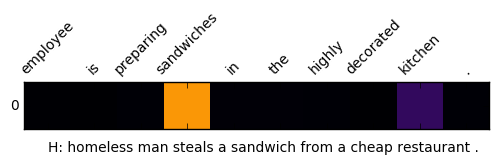

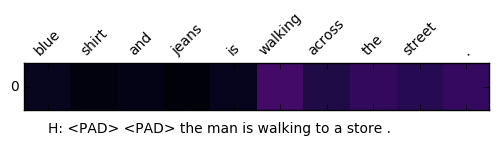

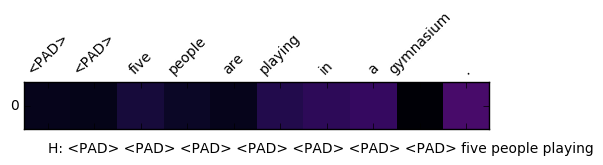

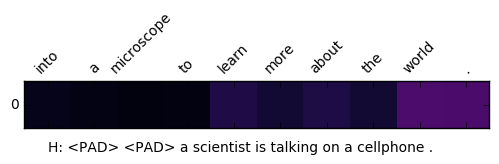

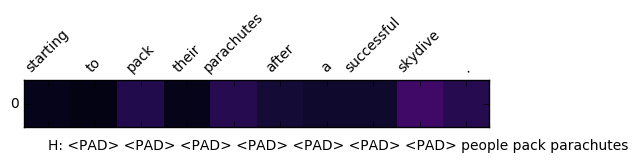

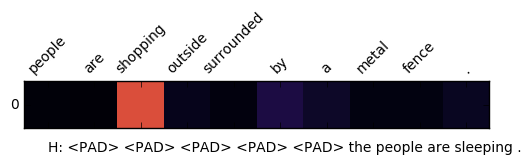

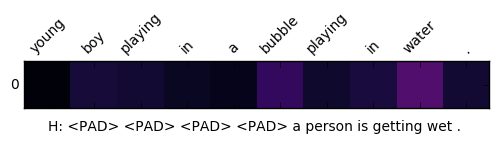

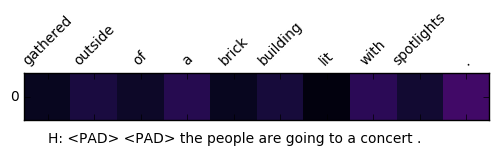

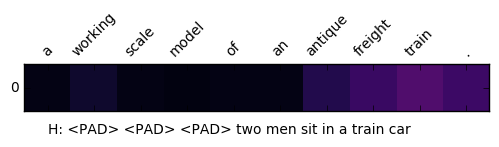

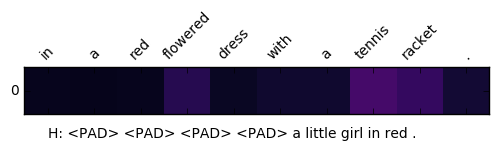

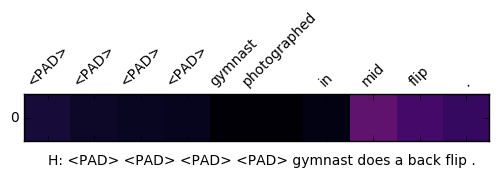

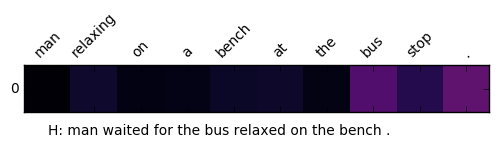

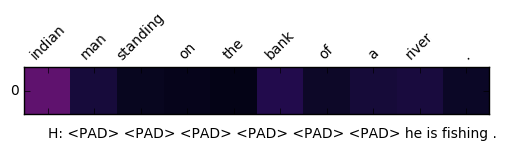

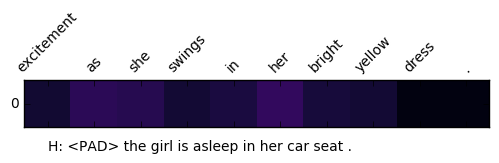

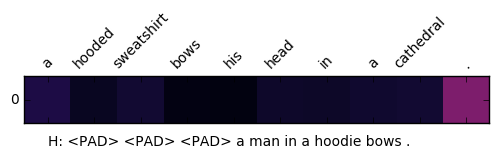

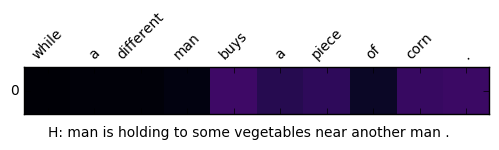

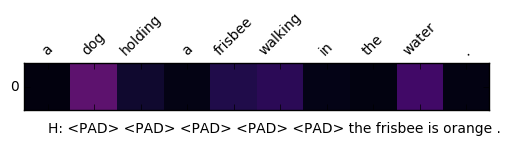

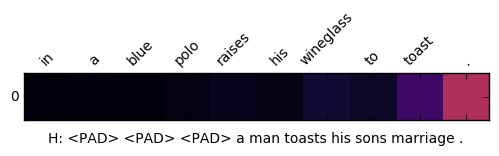

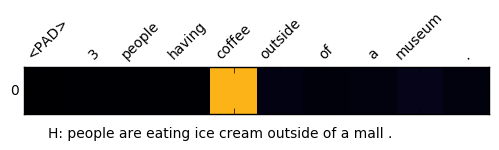

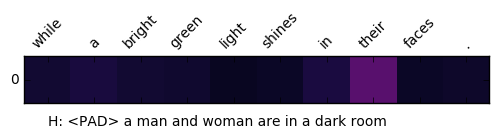

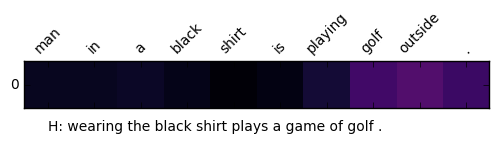

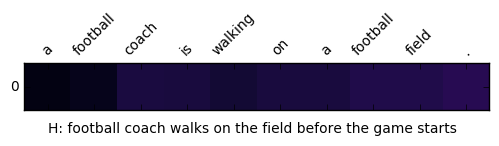

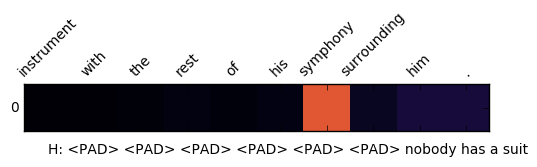

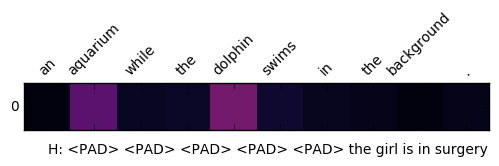

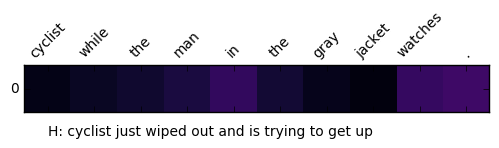

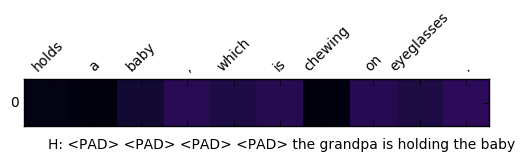

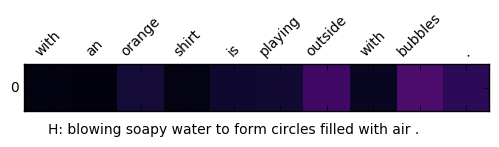

In [170]:
classifier.plot_attn(dev_set[0:50])